**Библиотеки Python для DS (семинары в записи)**

***Урок 9. Использование на практике методов снижения размерности***

Использование алгоритмов понижения размерности для улучшения классификации новостей (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html)

Цель задания: Исследовать влияние различных методов понижения размерности на качество классификации текстовых данных.

Датасет: Набор данных новостных статей
(датасет '20 Newsgroups' доступный в sklearn.datasets).

Задачи:

1. Загрузите датасет '20 Newsgroups' из sklearn.

2. Проведите предобработку данных (очистка текста, удаление стоп-слов, векторизация с использованием TF-IDF).

3. Примените к полученным векторам TF-IDF следующие методы понижения размерности:
— PCA (Principal Component Analysis)
— t-SNE (t-distributed Stochastic Neighbor Embedding)
— UMAP (Uniform Manifold Approximation and Projection).

4. После понижения размерности данных используйте любой метод машинного обучения для классификации новостей по темам.

5. Сравните качество классификации для каждого метода понижения размерности. Используйте метрики точности и F1-меру.

6. Визуализируйте двумерное представление данных для каждого метода понижения размерности, чтобы оценить, как алгоритмы справляются с сепарацией классов.

7. Напишите отчёт, в котором обсудите, какой метод понижения размерности оказал наиболее значительное влияние на качество классификации и почему.

Импорт библиотек

In [2]:
!pip install umap-learn[plot]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 5.7 MB/s eta 0:00:00


In [3]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import pandas as pd

Загрузим датасет и посмотрим на признаки

In [14]:
newsgroups_data = fetch_20newsgroups(subset='all')
data = {
    'text': newsgroups_data.data,
    'target': newsgroups_data.target}
df = pd.DataFrame(data)
df['category'] = df['target'].apply(lambda x: newsgroups_data.target_names[x])
df

,text,target,category
0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...,10,rec.sport.hockey
1,From: mblawson@midway.ecn.uoknor.edu (Matthew ...,3,comp.sys.ibm.pc.hardware
2,From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject...,17,talk.politics.mideast
3,From: guyd@austin.ibm.com (Guy Dawson)\nSubjec...,3,comp.sys.ibm.pc.hardware
4,From: Alexander Samuel McDiarmid <am2o+@andrew...,4,comp.sys.mac.hardware
...,...,...,...
18841,From: jim.zisfein@factory.com (Jim Zisfein) \n...,13,sci.med
18842,From: rdell@cbnewsf.cb.att.com (richard.b.dell...,12,sci.electronics
18843,From: westes@netcom.com (Will Estes)\nSubject:...,3,comp.sys.ibm.pc.hardware
18844,From: steve@hcrlgw (Steven Collins)\nSubject: ...,1,comp.graphics


In [15]:
print("Размер датасета:", df.shape)
print("Пропущенные значения:")
print(df.isnull().sum())

Размер датасета: (18846, 3)
Пропущенные значения:
text        0
target      0
category    0
dtype: int64


In [16]:
df.describe().T.style.background_gradient(cmap='YlOrRd')

,count,mean,std,min,25%,50%,75%,max
target,18846.000000,9.293166,5.562798,0.000000,5.000000,9.000000,14.000000,19.000000


In [17]:
df['text'].apply(len).describe()

,text
count,18846.000000
mean,1902.525894
std,3984.970264
min,115.000000
25%,751.000000
50%,1175.000000
75%,1874.750000
max,160616.000000


In [19]:
import seaborn as sns

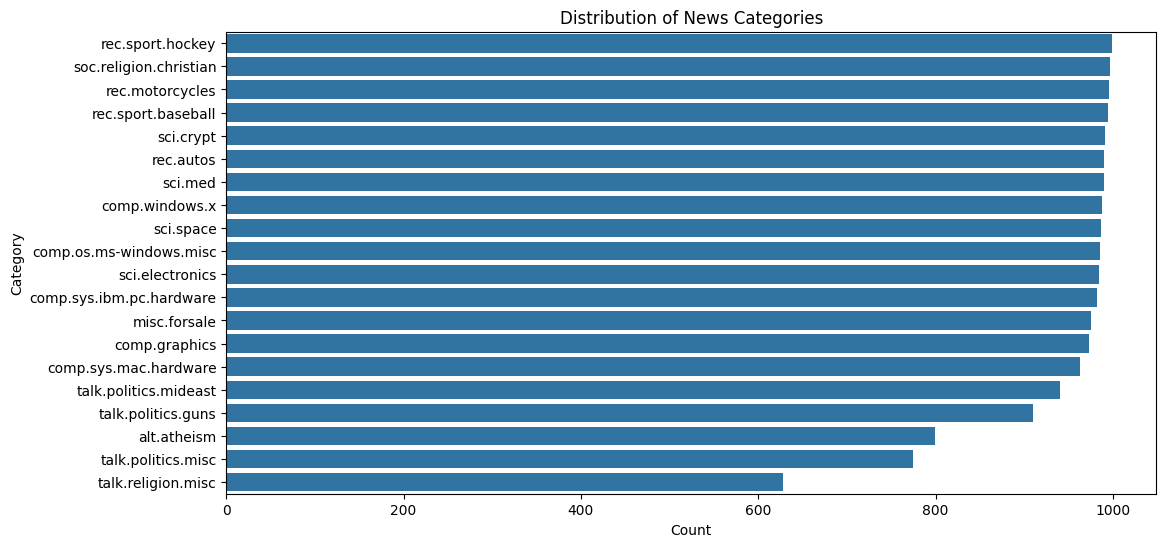

In [20]:
# Распределение классов
plt.figure(figsize=(12, 6))
sns.countplot(y='category', data=df, order=df['category'].value_counts().index)
plt.title('Distribution of News Categories')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()

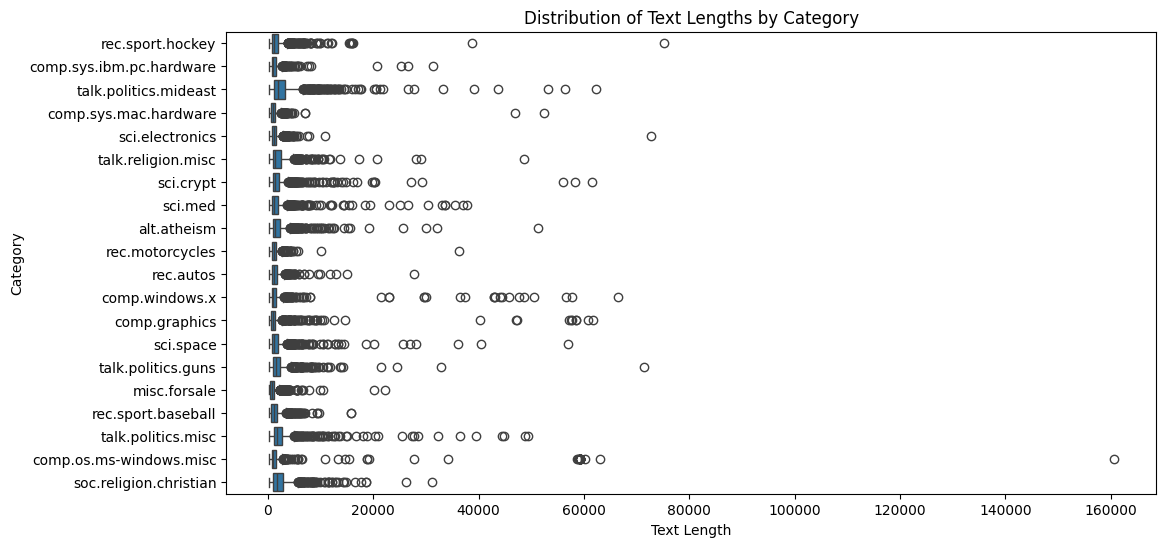

In [23]:
# Длина текстов в различных категориях
df['text_length'] = df['text'].apply(len)

plt.figure(figsize=(12, 6))
sns.boxplot(y='category', x='text_length', data=df, orient='h')
plt.title('Distribution of Text Lengths by Category')
plt.xlabel('Text Length')
plt.ylabel('Category')
plt.show()

In [24]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer

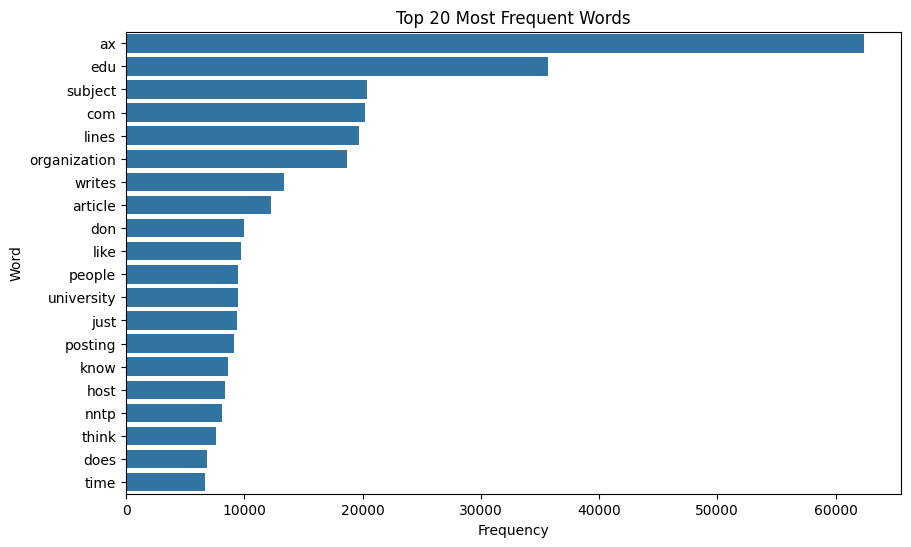

In [25]:
# Частотный анализ слов
vectorizer = CountVectorizer(stop_words='english', max_features=20)
X = vectorizer.fit_transform(df['text'])

# X.toarray(): Преобразует разреженную матрицу в плотный массив (numpy array), чтобы можно было легко суммировать частоты.
# sum(axis=0): Суммирует частоты слов по всем документам, создавая вектор частот,
# где каждая позиция соответствует суммарной частоте одного слова во всех документах.
word_freq = pd.DataFrame({
    'word': vectorizer.get_feature_names_out(),
    'frequency': X.toarray().sum(axis=0)
})

plt.figure(figsize=(10, 6))
sns.barplot(x='frequency', y='word', data=word_freq.sort_values(by='frequency', ascending=False))
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

Проведение предобработки данных

In [26]:
# remove=('headers', 'footers', 'quotes') - из текстов будут удалены заголовки, подписи и цитаты.
newsgroups_data = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

# Удаление стоп-слов
def remove_stopwords(text):
    words = text.split()
    words = [word for word in words if word.lower() not in ENGLISH_STOP_WORDS]
    return ' '.join(words)
cleaned_texts = [remove_stopwords(text) for text in newsgroups_data.data]

# Преобразование очищенного текста в TF-IDF признаки (будут выбраны только 5к наиболее значимых токенов)
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5_000)
tfidf_features = tfidf_vectorizer.fit_transform(cleaned_texts)

# Преобразование числовых меток категорий в строковые названия категорий
category_labels = [newsgroups_data.target_names[i] for i in newsgroups_data.target]

Применение методов пониженной размерности

In [27]:
#PCA
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(tfidf_features.toarray())

In [28]:
# Сколько информации сохранено в первых двух компонентах PCA
explained_variance = pca.explained_variance_ratio_
total_explained_variance = explained_variance.sum()
print(f'PCA - Total Explained Variance (information retained): {total_explained_variance:.2f}')

PCA - Total Explained Variance (information retained): 0.01


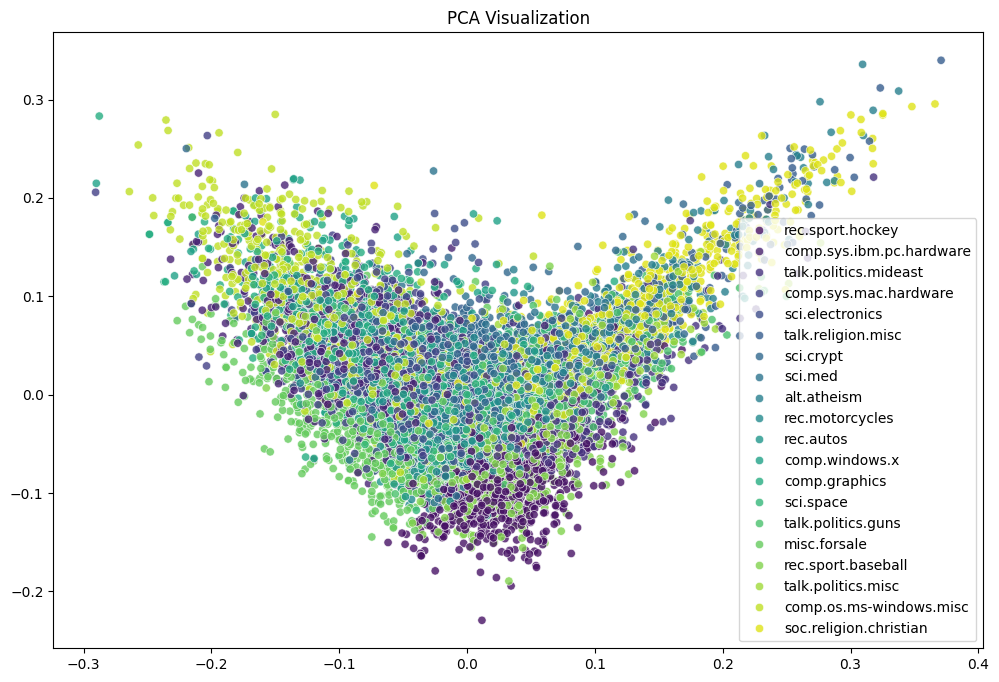

In [29]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=category_labels, palette='viridis', legend='full', alpha=0.8)
plt.title('PCA Visualization')
plt.show()

In [30]:
#t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(tfidf_features.toarray())

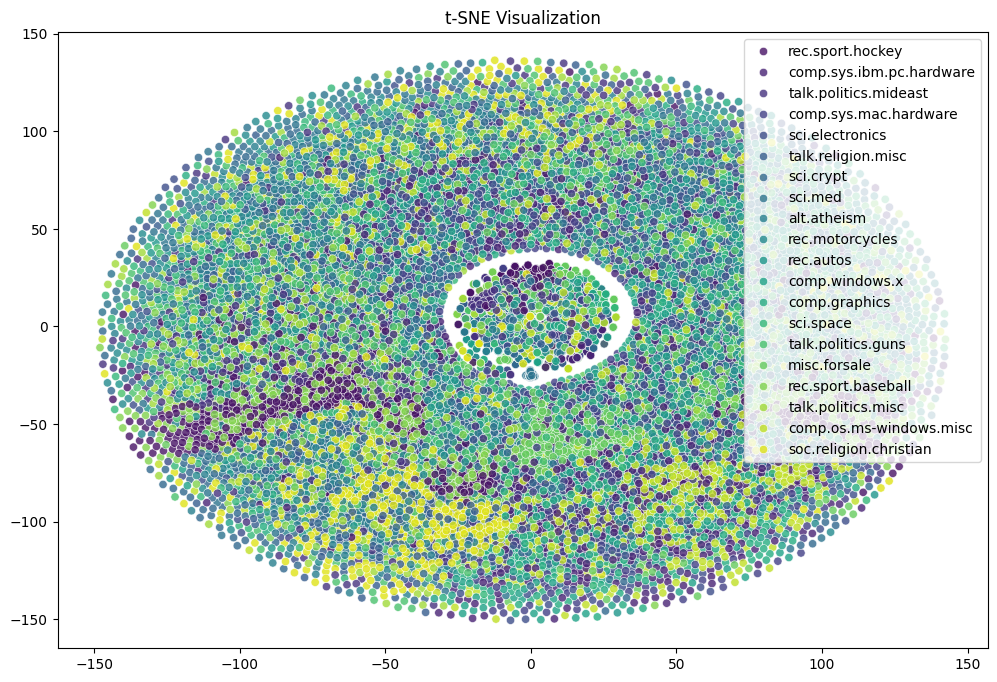

In [32]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=category_labels, palette='viridis', legend='full', alpha=0.8)
plt.title('t-SNE Visualization')
plt.show()

In [33]:
#UMAP
umap = UMAP(n_components=2, random_state=42)
umap_result = umap.fit_transform(tfidf_features.toarray())

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


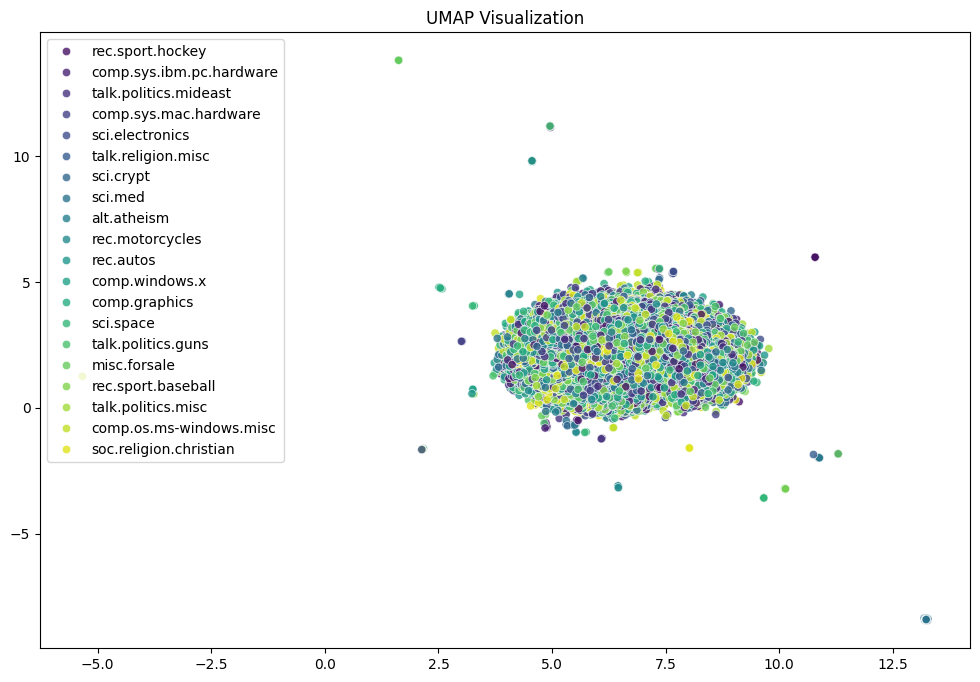

In [34]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x=umap_result[:, 0], y=umap_result[:, 1], hue=category_labels, palette='viridis', legend='full', alpha=0.8)
plt.title('UMAP Visualization')
plt.show()

Использование метода машинного обучения для классификации новостей по темам

In [37]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [38]:
#Метод опорных векторов (SVM)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, newsgroups_data.target, test_size=0.2, random_state=42)

# Train SVM classifier
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Predict on test set
y_pred = svm_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.49      0.55      0.52       151
           1       0.61      0.65      0.63       202
           2       0.65      0.62      0.63       195
           3       0.58      0.62      0.60       183
           4       0.75      0.61      0.67       205
           5       0.81      0.73      0.77       215
           6       0.75      0.70      0.73       193
           7       0.43      0.72      0.54       196
           8       0.61      0.64      0.63       168
           9       0.80      0.78      0.79       211
          10       0.95      0.81      0.88       198
          11       0.86      0.70      0.77       201
          12       0.53      0.61      0.57       202
          13       0.73      0.80      0.76       194
          14       0.69      0.71      0.70       189
          15       0.72      0.74      0.73       202
          16       0.68      0.68      0.68       188
          17       0.84    

In [41]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, newsgroups_data.target, test_size=0.2, random_state=42)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(pca_result, newsgroups_data.target, test_size=0.2, random_state=42)
X_train_tsne, X_test_tsne, y_train_tsne, y_test_tsne = train_test_split(tsne_result, newsgroups_data.target, test_size=0.2, random_state=42)
X_train_umap, X_test_umap, y_train_umap, y_test_umap = train_test_split(umap_result, newsgroups_data.target, test_size=0.2, random_state=42)

# Получение размеров данных
def get_shape(X):
    if hasattr(X, 'shape'):
        return X.shape[0]  # Размер первой размерности (количество примеров)
    else:
        return len(X)  # Для плотных матриц

In [42]:
# Функция для обучения модели и оценки метрик
def evaluate_model(X_train, X_test, y_train, y_test):
    #classifier = LogisticRegression(max_iter=1000, random_state=42)
    classifier = SVC(kernel='linear')

    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    #average='weighted' - взвешенное среднее
    f1 = f1_score(y_test, y_pred, average='weighted')

    return accuracy, f1

In [43]:
accuracy, f1 = evaluate_model(X_train, X_test, y_train, y_test)
accuracy_pca, f1_pca = evaluate_model(X_train_pca, X_test_pca, y_train_pca, y_test_pca)
accuracy_tsne, f1_tsne = evaluate_model(X_train_tsne, X_test_tsne, y_train_tsne, y_test_tsne)
accuracy_umap, f1_umap = evaluate_model(X_train_umap, X_test_umap, y_train_umap, y_test_umap)

print(f'Без понижения размерности - Accuracy: {accuracy:.2f}, F1-score: {f1:.2f}')
print(f'PCA - Accuracy: {accuracy_pca:.2f}, F1-score: {f1_pca:.2f}')
print(f't-SNE - Accuracy: {accuracy_tsne:.2f}, F1-score: {f1_tsne:.2f}')
print(f'UMAP - Accuracy: {accuracy_umap:.2f}, F1-score: {f1_umap:.2f}')

Без понижения размерности - Accuracy: 0.67, F1-score: 0.67
PCA - Accuracy: 0.21, F1-score: 0.16
t-SNE - Accuracy: 0.09, F1-score: 0.05
UMAP - Accuracy: 0.06, F1-score: 0.02


**Сводка результатов**

***Анализ***
1.	Без уменьшения размерности:
- Точность: 0,67 и F1-мера: 0,67 указывают на то, что модель работает достаточно хорошо при использовании полного представления данных в формате TF-IDF.
- Это говорит о том, что исходное пространство объектов содержит достаточную информацию для эффективной классификации.
2.	PCA:
- Точность: 0,21 и F1-оценка: 0,16 показывают значительное снижение производительности по сравнению с использованием полного набора функций.
- Метод главных компонент направлен на уменьшение размерности с сохранением дисперсии, но он может не учитывать важные локальные структуры, которые имеют решающее значение для классификации текстовых данных.
3.	t-SNE:
- Точность: 0,09 и F1-оценка: 0,05 указывают на дальнейшее снижение производительности.
- t-SNE — это в первую очередь инструмент для визуализации, который обычно не используется непосредственно для классификации из-за того, что он фокусируется на локальной структуре в ущерб глобальной.
4.	UMAP:
- Точность: 0,06 и F1-мера: 0,02 отражают худшие результаты среди протестированных методов.
- Хотя UMAP разработан таким образом, чтобы лучше сохранять как локальные, так и глобальные структуры, чем t-SNE, в данном контексте он, по-видимому, не даёт полезных характеристик для классификации.

***Заключение***

Результаты ясно показывают, что методы уменьшения размерности, в частности метод главных компонент, t-SNE и UMAP, не так эффективны, как использование полного набора признаков TF-IDF для классификации новостных статей из набора данных «20 групп новостей».
